# Libraries

In [1]:
! pip install transformers timm albumentations --quiet
! pip install ipywidgets --quiet

In [2]:
# Standard Libraries
import os
import random
from collections import Counter

# Numerical and Data Handling Libraries
import numpy as np
import pandas as pd

# Image Processing Libraries
import cv2
from PIL import Image

# Plotting and Visualization
import matplotlib.pyplot as plt

# PyTorch and Torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformers for Vision Models
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor

# Utility Libraries
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# jupyter nbextension enable --py widgetsnbextension
from google.colab import output
output.enable_custom_widget_manager()

# Data Import

In [3]:
train_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/train_images"
val_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/val_images"
test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/test_images/mistery_cat"

# Vision Transformer Model

In [4]:
from transformers import AutoImageProcessor, SwinForImageClassification

# Set the model name to Emiel's fine-tuned Swin model for bird classification
model_name = "Emiel/cub-200-bird-classifier-swin"

# Load the image processor automatically
processor = AutoImageProcessor.from_pretrained(model_name)

# Load the Swin model, specifying the number of classes (200 for CUB-200)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=20,  # Ensure this matches the number of classes in your dataset
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.95k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/786M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# import timm
# model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=20)

## Freeze all feature layers of Swin

In [6]:
# Freeze all parameters in the Swin backbone first.
for param in model.swin.parameters():
    param.requires_grad = False

# Unfreeze the parameters in the last block (layer) of the backbone.
# This assumes that your model.swin has an attribute 'layers' which is a ModuleList.
if hasattr(model.swin, "stages"):
    for param in model.swin.stages[-2].parameters():
        param.requires_grad = True
    print("Unfroze the last stage of the Swin backbone.")

# Ensure the classification head is trainable
for param in model.classifier.parameters():
    param.requires_grad = True

## Set layer-wise learning rate

In [7]:
from transformers import AdamW

# Set layer-wise learning rate (feature layer learning rate is lower)
optimizer = AdamW(
    [
        {"params": model.swin.parameters(), "lr": 1e-5},  # Feature extraction layer
        {"params": model.classifier.parameters(), "lr": 3e-4}  # Classification header
    ],
    weight_decay=0.01
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
# Verify that the classification layer is randomly initialized (correct state should be True)
print(model.classifier.weight.mean().item())  # Should be close to 0 (normal distribution initialization)
print(model.classifier.bias.mean().item())    # Should be close to 0

1.2871867511421442e-05
0.0


In [9]:
submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BirdDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.dataset = ImageFolder(root=main_dir, transform=transform)
        self.class_to_idx = self.dataset.class_to_idx
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((420, 420)),        
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.2),    
    transforms.RandomRotation(degrees=15),   
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),  
    transforms.RandomGrayscale(p=0.1),  
    transforms.ToTensor(),  
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])


val_transform = transforms.Compose([
    transforms.Resize((384, 384)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

train_dataset = BirdDataset(train_dir, transform=train_transform)
val_dataset = BirdDataset(val_dir, transform=val_transform)

def validate_class_order(train_class_order, submission_order):
    """Make sure the category names and order of both lists are exactly the same"""
    if len(train_class_order) != len(submission_order):
        raise ValueError(f"The number of categories does not match! Training set: {len(train_class_order)}, Submission Requirements: {len(submission_order)}")
    
    for train_cls, sub_cls in zip(train_class_order, submission_order):
        if train_cls != sub_cls:
            raise ValueError(f"Inconsistent order: training set '{train_cls}' vs Submission Requirements '{sub_cls}'")
    return True

train_class_order = sorted(train_dataset.class_to_idx.keys())

try:
    validate_class_order(train_class_order, submission_class_order)
except ValueError as e:
    print("Category order inconsistency detected, automatically correcting...")
    from torchvision.datasets import DatasetFolder
    
    class OrderedImageFolder(DatasetFolder):
        """Forces the data sets of categories to be loaded in a specified order"""
        def __init__(self, root, class_order, transform=None):
            self.class_order = class_order
            super().__init__(
                root,
                loader=lambda x: Image.open(x).convert("RGB"),
                extensions=('jpg', 'jpeg', 'png'),
                transform=transform,
                target_transform=None
            )
            
        def find_classes(self, directory):
            classes = self.class_order 
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx
    
    train_dataset = OrderedImageFolder(
        train_dir, 
        class_order=submission_class_order,
        transform=train_transform
    )
    val_dataset = OrderedImageFolder(
        val_dir,
        class_order=submission_class_order,
        transform=val_transform
    )
    
    print("Corrected category order：", train_dataset.classes)
    
# Category index validation (ensuring consistency with submission format)
assert sorted(train_dataset.class_to_idx.keys()) == sorted(submission_class_order), "Category order mismatch！"

Category order inconsistency detected, automatically correcting...
Corrected category order： ['Groove_billed_Ani', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Gray_Catbird', 'Brandt_Cormorant', 'Eastern_Towhee', 'Indigo_Bunting', 'Brewer_Blackbird', 'Painted_Bunting', 'Bobolink', 'Lazuli_Bunting', 'Yellow_headed_Blackbird', 'American_Crow', 'Fish_Crow', 'Brown_Creeper', 'Yellow_billed_Cuckoo', 'Yellow_breasted_Chat', 'Black_billed_Cuckoo', 'Gray_crowned_Rosy_Finch', 'Bronzed_Cowbird']


In [11]:
# import os
# import torch
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader

# # (Assuming train_dataset, val_dataset, model, optimizer, criterion, etc. are already defined)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# criterion = torch.nn.CrossEntropyLoss()
# model = model.to(device)

# class EarlyStopper:
#     def __init__(self, patience=5, min_delta=0):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.min_validation_loss = float('inf')

#     def early_stop(self, validation_loss):
#         if validation_loss < self.min_validation_loss:
#             self.min_validation_loss = validation_loss
#             self.counter = 0
#         elif validation_loss > (self.min_validation_loss + self.min_delta):
#             self.counter += 1
#             if self.counter >= self.patience:
#                 return True
#         return False

# def train_epoch(model, loader, optimizer, scaler):
#     model.train()
#     total_loss = 0
#     correct = 0
    
#     for images, labels in loader:
#         images = images.to(device)
#         labels = labels.to(device)
        
#         optimizer.zero_grad()
        
#         with torch.amp.autocast('cuda'):
#             outputs = model(images)
#             loss = criterion(outputs.logits, labels)
        
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        
#         total_loss += loss.item() * images.size(0)
#         preds = torch.argmax(outputs.logits, dim=1)
#         correct += (preds == labels).sum().item()
    
#     avg_loss = total_loss / len(loader.dataset)
#     accuracy = correct / len(loader.dataset)
#     return avg_loss, accuracy

# def validate(model, loader):
#     model.eval()
#     total_loss = 0
#     correct = 0
    
#     with torch.no_grad():
#         for images, labels in loader:
#             images = images.to(device)
#             labels = labels.to(device)
            
#             outputs = model(images)
#             loss = criterion(outputs.logits, labels)
            
#             total_loss += loss.item() * images.size(0)
#             preds = torch.argmax(outputs.logits, dim=1)
#             correct += (preds == labels).sum().item()
    
#     avg_loss = total_loss / len(loader.dataset)
#     accuracy = correct / len(loader.dataset)
#     return avg_loss, accuracy

# scaler = torch.amp.GradScaler('cuda')
# early_stopper = EarlyStopper(patience=10, min_delta=0.0003)
# history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# # Variables to track the best validation accuracy
# best_val_acc = 0.0
# best_model_path = "/kaggle/working/best_model.pth"

# for epoch in range(20):
#     train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler)
#     val_loss, val_acc = validate(model, val_loader)
    
#     history['train_loss'].append(train_loss)
#     history['val_loss'].append(val_loss)
#     history['train_acc'].append(train_acc)
#     history['val_acc'].append(val_acc)
    
#     print(f"Epoch {epoch+1:02d}:")
#     print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
#     print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}\n")
    
#     # Save model parameters if current validation accuracy is the best so far
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(model.state_dict(), best_model_path)
#         print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    
#     if early_stopper.early_stop(val_loss):
#         print("Early stopping triggered!")
#         break

# # Plot training curves
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history['train_loss'], label='Train')
# plt.plot(history['val_loss'], label='Validation')
# plt.title('Loss Curve')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['train_acc'], label='Train')
# plt.plot(history['val_acc'], label='Validation')
# plt.title('Accuracy Curve')
# plt.legend()
# plt.show()


======== Fold 1/5 ========


Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Acc = 0.4352, Val Acc = 0.7979
New best model saved with validation accuracy: 0.7979
Epoch 2: Train Acc = 0.7957, Val Acc = 0.8138
New best model saved with validation accuracy: 0.8138
Epoch 3: Train Acc = 0.8665, Val Acc = 0.7819
Epoch 4: Train Acc = 0.8692, Val Acc = 0.8670
New best model saved with validation accuracy: 0.8670
Epoch 5: Train Acc = 0.8905, Val Acc = 0.8404
Epoch 6: Train Acc = 0.8825, Val Acc = 0.8457
Epoch 7: Train Acc = 0.8972, Val Acc = 0.8883
New best model saved with validation accuracy: 0.8883
Epoch 8: Train Acc = 0.9025, Val Acc = 0.8511
Epoch 9: Train Acc = 0.9079, Val Acc = 0.8830
Epoch 10: Train Acc = 0.9252, Val Acc = 0.8564
Epoch 11: Train Acc = 0.9239, Val Acc = 0.8777
Epoch 12: Train Acc = 0.9319, Val Acc = 0.8777
Epoch 13: Train Acc = 0.9319, Val Acc = 0.8564
Epoch 14: Train Acc = 0.9372, Val Acc = 0.8617
Epoch 15: Train Acc = 0.9332, Val Acc = 0.8830
Epoch 16: Train Acc = 0.9332, Val Acc = 0.8564
Epoch 17: Train Acc = 0.9479, Val Acc = 0

Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Acc = 0.4099, Val Acc = 0.7394
Epoch 2: Train Acc = 0.8131, Val Acc = 0.8298
Epoch 3: Train Acc = 0.8358, Val Acc = 0.8298
Epoch 4: Train Acc = 0.8611, Val Acc = 0.8617
Epoch 5: Train Acc = 0.8718, Val Acc = 0.8511
Epoch 6: Train Acc = 0.8879, Val Acc = 0.8670
Epoch 7: Train Acc = 0.8972, Val Acc = 0.8723
Epoch 8: Train Acc = 0.8999, Val Acc = 0.8883
Epoch 9: Train Acc = 0.8972, Val Acc = 0.8883
Epoch 10: Train Acc = 0.9065, Val Acc = 0.8989
New best model saved with validation accuracy: 0.8989
Epoch 11: Train Acc = 0.9239, Val Acc = 0.9096
New best model saved with validation accuracy: 0.9096
Epoch 12: Train Acc = 0.9266, Val Acc = 0.8617
Epoch 13: Train Acc = 0.9199, Val Acc = 0.9043
Epoch 14: Train Acc = 0.9359, Val Acc = 0.9043
Epoch 15: Train Acc = 0.9399, Val Acc = 0.8617
Epoch 16: Train Acc = 0.9439, Val Acc = 0.8989
Epoch 17: Train Acc = 0.9519, Val Acc = 0.8777
Epoch 18: Train Acc = 0.9453, Val Acc = 0.8723
Epoch 19: Train Acc = 0.9533, Val Acc = 0.8883
Epoch 20

Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Acc = 0.4520, Val Acc = 0.7807
Epoch 2: Train Acc = 0.8053, Val Acc = 0.8075
Epoch 3: Train Acc = 0.8293, Val Acc = 0.7968
Epoch 4: Train Acc = 0.8667, Val Acc = 0.8556
Epoch 5: Train Acc = 0.8787, Val Acc = 0.8770
Epoch 6: Train Acc = 0.8893, Val Acc = 0.8610
Epoch 7: Train Acc = 0.8960, Val Acc = 0.8396
Epoch 8: Train Acc = 0.9107, Val Acc = 0.8610
Epoch 9: Train Acc = 0.9160, Val Acc = 0.8717
Epoch 10: Train Acc = 0.9213, Val Acc = 0.8610
Epoch 11: Train Acc = 0.9293, Val Acc = 0.8717
Epoch 12: Train Acc = 0.9307, Val Acc = 0.8877
Epoch 13: Train Acc = 0.9333, Val Acc = 0.8930
Epoch 14: Train Acc = 0.9400, Val Acc = 0.8717
Epoch 15: Train Acc = 0.9360, Val Acc = 0.8877
Epoch 16: Train Acc = 0.9400, Val Acc = 0.8930
Epoch 17: Train Acc = 0.9387, Val Acc = 0.8824
Epoch 18: Train Acc = 0.9267, Val Acc = 0.8717
Epoch 19: Train Acc = 0.9333, Val Acc = 0.8663
Epoch 20: Train Acc = 0.9387, Val Acc = 0.8717

======== Fold 4/5 ========


Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Acc = 0.4907, Val Acc = 0.7487
Epoch 2: Train Acc = 0.7987, Val Acc = 0.8449
Epoch 3: Train Acc = 0.8427, Val Acc = 0.8877
Epoch 4: Train Acc = 0.8840, Val Acc = 0.8770
Epoch 5: Train Acc = 0.8760, Val Acc = 0.8449
Epoch 6: Train Acc = 0.8987, Val Acc = 0.8930
Epoch 7: Train Acc = 0.9120, Val Acc = 0.9198
Epoch 8: Train Acc = 0.9080, Val Acc = 0.8717
Epoch 9: Train Acc = 0.8960, Val Acc = 0.9198
Epoch 10: Train Acc = 0.9147, Val Acc = 0.9037
Epoch 11: Train Acc = 0.9267, Val Acc = 0.9198
Epoch 12: Train Acc = 0.9293, Val Acc = 0.9037
Epoch 13: Train Acc = 0.9080, Val Acc = 0.8877
Epoch 14: Train Acc = 0.9307, Val Acc = 0.9144
Epoch 15: Train Acc = 0.9240, Val Acc = 0.9144
Epoch 16: Train Acc = 0.9333, Val Acc = 0.8930
Epoch 17: Train Acc = 0.9373, Val Acc = 0.9144
Epoch 18: Train Acc = 0.9373, Val Acc = 0.8717
Epoch 19: Train Acc = 0.9213, Val Acc = 0.8877
Epoch 20: Train Acc = 0.9440, Val Acc = 0.9091

======== Fold 5/5 ========


Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Acc = 0.4293, Val Acc = 0.7433
Epoch 2: Train Acc = 0.8107, Val Acc = 0.8021
Epoch 3: Train Acc = 0.8520, Val Acc = 0.8182
Epoch 4: Train Acc = 0.8667, Val Acc = 0.8556
Epoch 5: Train Acc = 0.8827, Val Acc = 0.8128
Epoch 6: Train Acc = 0.9027, Val Acc = 0.7914
Epoch 7: Train Acc = 0.8880, Val Acc = 0.8717
Epoch 8: Train Acc = 0.9040, Val Acc = 0.8717
Epoch 9: Train Acc = 0.9133, Val Acc = 0.7968
Epoch 10: Train Acc = 0.9333, Val Acc = 0.8717
Epoch 11: Train Acc = 0.9120, Val Acc = 0.8556
Epoch 12: Train Acc = 0.9373, Val Acc = 0.8556
Epoch 13: Train Acc = 0.9533, Val Acc = 0.8235
Epoch 14: Train Acc = 0.9347, Val Acc = 0.8663
Epoch 15: Train Acc = 0.9427, Val Acc = 0.8235
Epoch 16: Train Acc = 0.9320, Val Acc = 0.8770
Epoch 17: Train Acc = 0.9387, Val Acc = 0.8717
Epoch 18: Train Acc = 0.9533, Val Acc = 0.8770
Epoch 19: Train Acc = 0.9333, Val Acc = 0.8824
Epoch 20: Train Acc = 0.9560, Val Acc = 0.8770

Final Average Validation Accuracy: 0.8922


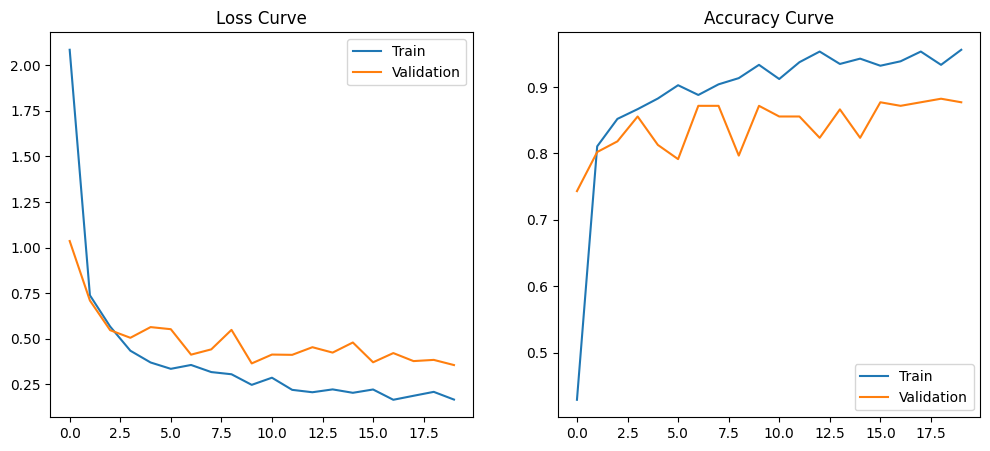

In [12]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Define K-Fold settings
K = 5  # You can change to 10 if needed
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the full dataset
full_dataset = BirdDataset(train_dir, transform=train_transform)
targets = [label for _, label in full_dataset]  # Extract labels for stratification

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# Store validation accuracies
fold_accuracies = []
best_val_acc = 0.0
best_model_path = "/kaggle/working/best_model.pth"

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n======== Fold {fold+1}/{K} ========")

    # Create train and validation subsets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)

    # Load the model and reset classification layer
    model = SwinForImageClassification.from_pretrained(model_name, num_labels=20, ignore_mismatched_sizes=True).to(device)
    
    # Freeze feature extractor and train classifier
    for param in model.swin.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Define optimizer and loss function
    optimizer = AdamW(
        [
            {"params": model.swin.parameters(), "lr": 1e-5},
            {"params": model.classifier.parameters(), "lr": 3e-4}
        ],
        weight_decay=0.01
    )
    criterion = torch.nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler('cuda')
    early_stopper = EarlyStopper(patience=10, min_delta=0.0003)

    # Store history for plots
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs.logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()

        train_acc = correct / len(train_subset)
        train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        total_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs.logits, labels)

                total_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()

        val_acc = correct / len(val_subset)
        val_loss = total_loss / len(val_loader)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        # Save the best model across all folds
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with validation accuracy: {val_acc:.4f}")

        if early_stopper.early_stop(val_loss):
            print("Early stopping triggered!")
            break

    fold_accuracies.append(val_acc)

# Print final cross-validation accuracy
print(f"\nFinal Average Validation Accuracy: {np.mean(fold_accuracies):.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [13]:
import os
import torch

# Define the directory where you'll save the best model in Hugging Face format.
save_dir = "/kaggle/working/swin_model"
os.makedirs(save_dir, exist_ok=True)

# Load the best model state dictionary (from the training loop).
best_state_dict = torch.load(best_model_path, map_location=torch.device("cpu"))
model.load_state_dict(best_state_dict)

# Save the best model in Hugging Face format.
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

# Optionally, save additional information such as class mapping and training configuration.
class_info = {
    "class_order": submission_class_order,
    "class_to_idx": train_dataset.class_to_idx,
    "idx_to_class": {v: k for k, v in train_dataset.class_to_idx.items()}
}
torch.save(class_info, os.path.join(save_dir, "class_info.pth"))

train_config = {
    "epochs_trained": len(history['train_loss']),
    "best_val_acc": max(history['val_acc']),
    "optimizer_state": optimizer.state_dict()
}
torch.save(train_config, os.path.join(save_dir, "train_config.pth"))

# Also save the class order as a plain text file for reference.
with open(os.path.join(save_dir, "class_info.txt"), "w") as f:
    f.write("\n".join(submission_class_order))

print(f"Best model saved in Hugging Face format to: {save_dir}")

<ipython-input-13-cf258f9b96a8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load(best_model_path, map_location=torch.device("cpu"))


Best model saved in Hugging Face format to: /kaggle/working/swin_model


# Test and Generate Submission File

In [14]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, SwinForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

model_dir = "/kaggle/working/swin_model" 
processor = AutoImageProcessor.from_pretrained(model_dir)

expected_size = 384
val_transform = transforms.Compose([
    transforms.Resize((expected_size, expected_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

class CompetitionTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_files = sorted(os.listdir(test_dir))  # 保持严格顺序
        self.image_paths = [os.path.join(test_dir, f) for f in self.image_files]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(self.image_paths[idx])

def load_trained_model(model_dir, class_order):
    model = SwinForImageClassification.from_pretrained(model_dir).to(device)
    
    config = model.config
    if config.id2label != {i: cls for i, cls in enumerate(class_order)}:
        print("Warning: The order of categories in the model configuration is inconsistent with the submission requirements. Overriding with submission order.")
        config.id2label = {i: cls for i, cls in enumerate(class_order)}
        config.label2id = {cls: i for i, cls in enumerate(class_order)}
    
    model.eval()
    return model

def generate_submission(test_dir, model_dir, output_csv="submission.csv"):
    test_dataset = CompetitionTestDataset(test_dir, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
    
    model = load_trained_model(model_dir, submission_class_order)
    
    filenames = []
    predictions = []
    
    with torch.no_grad():
        for images, paths in test_loader:
            outputs = model(images.to(device))
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            filenames.extend(paths)
            predictions.extend(batch_preds.tolist())
    
    submission_df = pd.DataFrame({
        'path': filenames,
        'class_idx': predictions
    })
    
    print("\nValidation Results:")
    print(f"Total Samples: {len(submission_df)}")
    print(f"Number of unique file names: {submission_df['path'].nunique()}")
    print(f"Predicted category distribution:\n{submission_df['class_idx'].value_counts().sort_index()}")
    
    submission_df.to_csv(output_csv, index=False)
    print(f"\nSubmission CSV saved to: {output_csv}")

if __name__ == "__main__":
    test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/test_images/mistery_cat"
    generate_submission(test_dir, model_dir)


Validation Results:
Total Samples: 400
Number of unique file names: 400
Predicted category distribution:
class_idx
0     16
1     19
2     21
3     21
4     15
5     20
6     20
7     21
8     25
9     20
10    18
11    19
12    16
13    19
14    22
15    17
16    30
17    22
18    20
19    19
Name: count, dtype: int64

Submission CSV saved to: submission.csv
